In [1]:
import pandas as pd
import numpy as np

# 1. Load the dataset from the specified path
# Using forward slashes is the best way to avoid syntax errors on any operating system.
df = pd.read_csv("C:/Users/sathr/OneDrive/Desktop/AIML internship/smart_logistics_dataset.csv")

# 2. Data Cleaning and Preprocessing
# Convert 'Timestamp' to a proper datetime format
df['Timestamp'] = pd.to_datetime(df['Timestamp'])

# Fill missing values in 'Logistics_Delay_Reason' with a new category.
# This modern syntax avoids the FutureWarning.
df['Logistics_Delay_Reason'] = df['Logistics_Delay_Reason'].fillna('No Delay Reason')

# 3. Feature Engineering
# Create time-based features from the Timestamp
df['hour'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.dayofweek
df['day_of_year'] = df['Timestamp'].dt.dayofyear

# Define a temperature threshold (e.g., 5 degrees C) and calculate the thermal abuse score
temp_threshold = 5  
df['thermal_abuse_score'] = df['Temperature'].apply(lambda temp: max(0, temp - temp_threshold))

# Sort the data by Asset_ID and Timestamp for accurate cumulative sum
df.sort_values(by=['Asset_ID', 'Timestamp'], inplace=True)

# Calculate the cumulative thermal abuse score for each truck
df['cumulative_thermal_abuse'] = df.groupby('Asset_ID')['thermal_abuse_score'].cumsum()

# Create the binary spoilage flag based on a threshold
spoilage_threshold = 800
df['spoilage_flag'] = (df['cumulative_thermal_abuse'] > spoilage_threshold).astype(int)

# 4. Final Feature Selection
# Create a new DataFrame with only the relevant columns we planned for
columns_to_keep = [
    'Timestamp', 'Asset_ID', 'Temperature', 'Humidity', 
    'Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason', 
    'hour', 'day_of_week', 'day_of_year', 
    'thermal_abuse_score', 'cumulative_thermal_abuse', 'spoilage_flag'
]

df_final = df[columns_to_keep]

# 5. Save the final updated DataFrame to a new CSV file
df_final.to_csv('smart_logistics_updated.csv', index=False)

print("Data preprocessing and feature engineering is completed.")
print("The final cleaned and prepared dataset has been saved to 'smart_logistics_updated.csv'.")

Data preprocessing and feature engineering is completed.
The final cleaned and prepared dataset has been saved to 'smart_logistics_updated.csv'.


In [3]:
# Get the total number of spoiled items
total_spoiled = df['spoilage_flag'].sum()

print(f"Total number of spoiled items: {total_spoiled}")

Total number of spoiled items: 581


In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
from sklearn.metrics import accuracy_score

# --- This is a new code block for WEEK 2 ---

# 1. Load the final prepared dataset from Week 1
try:
    df = pd.read_csv('smart_logistics_updated.csv')
except FileNotFoundError:
    print("Error: 'smart_logistics_updated.csv' not found. Please make sure you completed Week 1 and saved the final CSV.")
    exit()

# 2. Separate Features (X) and Target Variable (y)
X = df.drop(columns=['Timestamp', 'Asset_ID', 'thermal_abuse_score', 'cumulative_thermal_abuse', 'spoilage_flag'])
y = df['spoilage_flag']

# 3. Handle Categorical Data
X = pd.get_dummies(X, columns=['Shipment_Status', 'Traffic_Status', 'Logistics_Delay_Reason'], drop_first=True)

# 4. Split the Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 5. Initialize and Train Different Models
# Model 1: Random Forest Classifier
print("Training Random Forest Classifier...")
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_pred)
print(f"Random Forest Classifier Accuracy: {rf_accuracy:.4f}")

# Model 2: XGBoost Classifier (FIXED)
print("\nTraining XGBoost Classifier...")
xgb_model = xgb.XGBClassifier(n_estimators=100, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_pred)
print(f"XGBoost Classifier Accuracy: {xgb_accuracy:.4f}")

# Model 3: Logistic Regression
print("\nTraining Logistic Regression...")
lr_model = LogisticRegression(random_state=42, solver='liblinear')
lr_model.fit(X_train, y_train)
lr_pred = lr_model.predict(X_test)
lr_accuracy = accuracy_score(y_test, lr_pred)
print(f"Logistic Regression Accuracy: {lr_accuracy:.4f}")


Training Random Forest Classifier...
Random Forest Classifier Accuracy: 0.9350

Training XGBoost Classifier...
XGBoost Classifier Accuracy: 0.9500

Training Logistic Regression...
Logistic Regression Accuracy: 0.9450


In [22]:
# Model 4: Support Vector Machine (SVM)
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

print("\nTraining Support Vector Machine (SVM)...")
svm_model = SVC(kernel='linear', random_state=42)
svm_model.fit(X_train, y_train)
svm_pred = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_pred)
print(f"Support Vector Machine (SVM) Accuracy: {svm_accuracy:.4f}")


Training Support Vector Machine (SVM)...
Support Vector Machine (SVM) Accuracy: 0.9300


In [24]:
# Model 5: K-Nearest Neighbors (KNN)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

print("\nTraining K-Nearest Neighbors (KNN)...")
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
knn_pred = knn_model.predict(X_test)
knn_accuracy = accuracy_score(y_test, knn_pred)
print(f"K-Nearest Neighbors (KNN) Accuracy: {knn_accuracy:.4f}")


Training K-Nearest Neighbors (KNN)...
K-Nearest Neighbors (KNN) Accuracy: 0.9300


In [32]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Make predictions on the test data
xgb_pred = xgb_model.predict(X_test)

# Calculate key metrics
accuracy = accuracy_score(y_test, xgb_pred)
precision = precision_score(y_test, xgb_pred, zero_division=0)
recall = recall_score(y_test, xgb_pred, zero_division=0)
f1 = f1_score(y_test, xgb_pred, zero_division=0)
cm = confusion_matrix(y_test, xgb_pred)

print("--- XGBoost Model Evaluation ---")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print("\nConfusion Matrix:")
print(cm)

--- XGBoost Model Evaluation ---
Accuracy: 0.9500
Precision: 0.9741
Recall: 0.9417
F1-Score: 0.9576

Confusion Matrix:
[[ 77   3]
 [  7 113]]


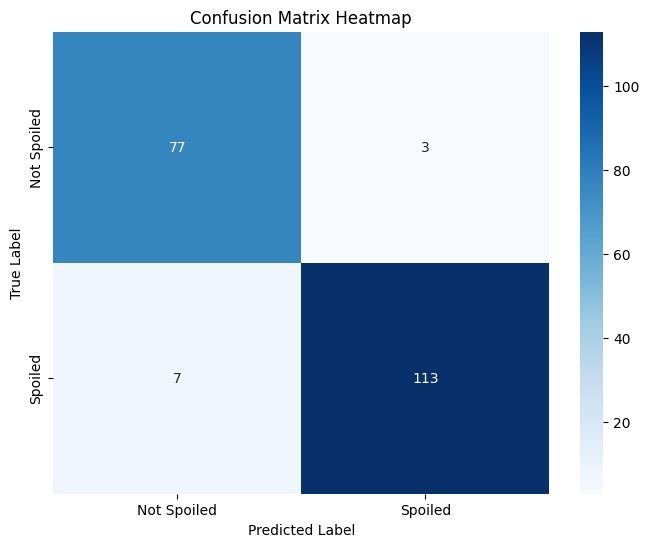

In [34]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a heatmap of the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Spoiled', 'Spoiled'],
            yticklabels=['Not Spoiled', 'Spoiled'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Heatmap')
plt.show()

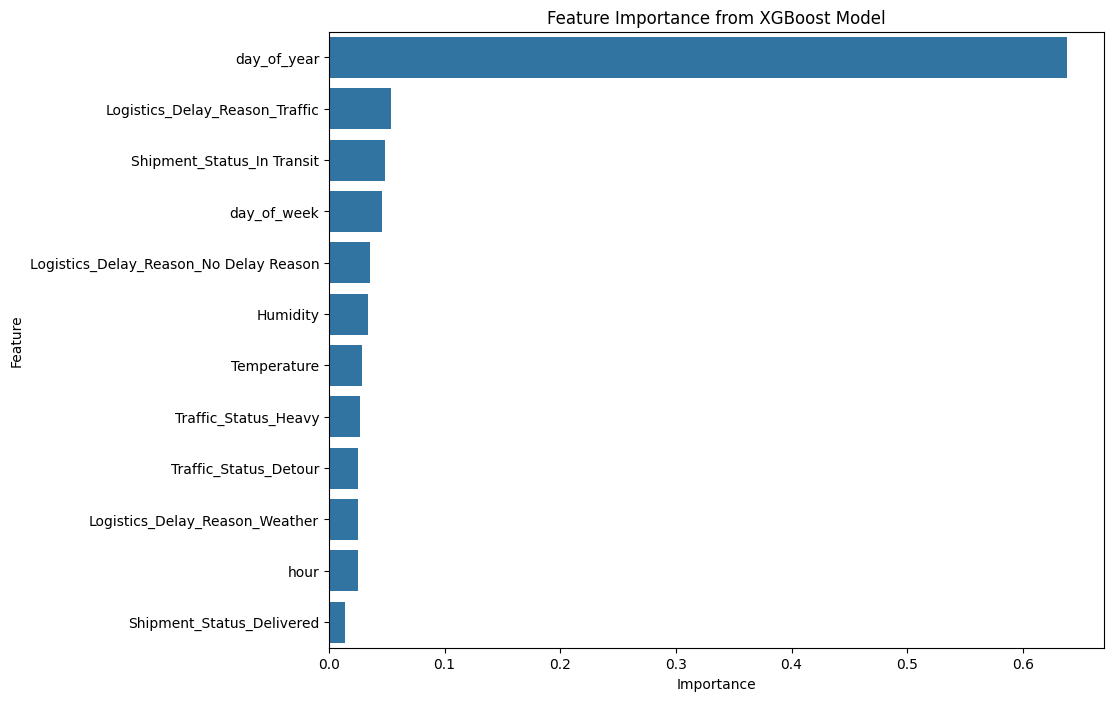

In [36]:
importances = xgb_model.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': importances})

# Sort the features by importance
feature_importance_df.sort_values(by='importance', ascending=False, inplace=True)

# Plot the feature importance
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title('Feature Importance from XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()